<a href="https://colab.research.google.com/github/bharatgirdhar/EVA6_Session4/blob/main/EVA6_Session_4_Assigment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 24, 3, padding=1) #28 - 3*3*16
        self.conv2 = nn.Conv2d(24, 32, 3, padding=1)#28-- 
        self.pool1 = nn.MaxPool2d(2, 2)#14
        self.dropout1=nn.Dropout(0.2)
        self.BatchNorm1=nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 16, 1)#1
        self.conv4 = nn.Conv2d(16, 32, 3)#12
        self.pool2 = nn.MaxPool2d(2, 2)#6
        self.dropout2=nn.Dropout(0.2)
        self.BatchNorm2=nn.BatchNorm2d(32)
        self.conv5 = nn.Conv2d(32, 16, 1)#6
        self.conv6 = nn.Conv2d(16, 32, 3)#4
        self.gap1=nn.AdaptiveAvgPool2d(1)

        self.fc1=nn.Linear(in_features=32, out_features=10)


    def forward(self, x):
        x = self.BatchNorm1(self.dropout1(self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))))
        #print(x.shape)
        x = self.BatchNorm2(self.dropout2(self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))))
        #print(x.shape)
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        #x = self.conv7(x)
        #print(x.shape)
        x = self.gap1(x)
        #print(x.shape)
        
        
        x = x.view(-1, 32)
        #print(x.shape)
        x=self.fc1(x)
        return F.log_softmax(x)

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 28, 28]             240
            Conv2d-2           [-1, 32, 28, 28]           6,944
         MaxPool2d-3           [-1, 32, 14, 14]               0
           Dropout-4           [-1, 32, 14, 14]               0
       BatchNorm2d-5           [-1, 32, 14, 14]              64
            Conv2d-6           [-1, 16, 14, 14]             528
            Conv2d-7           [-1, 32, 12, 12]           4,640
         MaxPool2d-8             [-1, 32, 6, 6]               0
           Dropout-9             [-1, 32, 6, 6]               0
      BatchNorm2d-10             [-1, 32, 6, 6]              64
           Conv2d-11             [-1, 16, 6, 6]             528
           Conv2d-12             [-1, 32, 4, 4]           4,640
AdaptiveAvgPool2d-13             [-1, 32, 1, 1]               0
           Linear-14                   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:


torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        #transforms.RandomRotation(degrees=(-30,30)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss=0
    pbar = tqdm(train_loader, leave="false")
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_loss += loss
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
    print(f"Train Loss{train_loss/len(train_loader.dataset)}")


def test(model, device, test_loader,epoch):
    model.eval()
    test_loss = 0
    correct = 0
    missed_pred=[]
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data_copy=data
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            if epoch==19:
              for i in range(len(target)):
                if pred[i]!=target[i]:
                  
                  plt.imshow(data_copy[i].squeeze(0))
                  plt.show()
    test_loss /= len(test_loader.dataset)
    print('\nEPOCH : ',epoch)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    

loss=0.18407170474529266 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.85it/s]

Train Loss0.003260332625359297



  0%|          | 0/469 [00:00<?, ?it/s]


EPOCH :  1

Test set: Average loss: 0.0742, Accuracy: 9776/10000 (98%)



loss=0.07512999325990677 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.47it/s]

Train Loss0.000750625622458756



  0%|          | 0/469 [00:00<?, ?it/s]


EPOCH :  2

Test set: Average loss: 0.0524, Accuracy: 9847/10000 (98%)



loss=0.11056102067232132 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.24it/s]

Train Loss0.000584601832088083



  0%|          | 0/469 [00:00<?, ?it/s]


EPOCH :  3

Test set: Average loss: 0.0505, Accuracy: 9840/10000 (98%)



loss=0.032407816499471664 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 39.83it/s]


Train Loss0.00047768696094863117


  0%|          | 0/469 [00:00<?, ?it/s]


EPOCH :  4

Test set: Average loss: 0.0422, Accuracy: 9866/10000 (99%)



loss=0.0446721650660038 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 39.14it/s]

Train Loss0.00042465218575671315



  0%|          | 0/469 [00:00<?, ?it/s]


EPOCH :  5

Test set: Average loss: 0.0432, Accuracy: 9863/10000 (99%)



loss=0.03705419600009918 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 39.18it/s]


Train Loss0.0003773195203393698


  0%|          | 0/469 [00:00<?, ?it/s]


EPOCH :  6

Test set: Average loss: 0.0405, Accuracy: 9872/10000 (99%)



loss=0.14735184609889984 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 39.76it/s]


Train Loss0.0003635298053268343


  0%|          | 0/469 [00:00<?, ?it/s]


EPOCH :  7

Test set: Average loss: 0.0297, Accuracy: 9913/10000 (99%)



loss=0.0036628618836402893 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 39.86it/s]

Train Loss0.0003254644980188459



  0%|          | 0/469 [00:00<?, ?it/s]


EPOCH :  8

Test set: Average loss: 0.0329, Accuracy: 9897/10000 (99%)



loss=0.002700421027839184 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.27it/s]

Train Loss0.00030075424001552165



  0%|          | 0/469 [00:00<?, ?it/s]


EPOCH :  9

Test set: Average loss: 0.0286, Accuracy: 9917/10000 (99%)



loss=0.02699659951031208 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.59it/s]

Train Loss0.00027203961508348584



  0%|          | 0/469 [00:00<?, ?it/s]


EPOCH :  10

Test set: Average loss: 0.0265, Accuracy: 9916/10000 (99%)



loss=0.11927878111600876 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.39it/s]

Train Loss0.0002864870766643435



  0%|          | 0/469 [00:00<?, ?it/s]


EPOCH :  11

Test set: Average loss: 0.0266, Accuracy: 9921/10000 (99%)



loss=0.023260699585080147 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.64it/s]


Train Loss0.0002651663380675018


  0%|          | 0/469 [00:00<?, ?it/s]


EPOCH :  12

Test set: Average loss: 0.0249, Accuracy: 9926/10000 (99%)



loss=0.016881288960576057 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 37.96it/s]

Train Loss0.00026038926444016397



  0%|          | 0/469 [00:00<?, ?it/s]


EPOCH :  13

Test set: Average loss: 0.0306, Accuracy: 9902/10000 (99%)



loss=0.0742684081196785 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.06it/s]

Train Loss0.0002500869450159371



  0%|          | 0/469 [00:00<?, ?it/s]


EPOCH :  14

Test set: Average loss: 0.0251, Accuracy: 9910/10000 (99%)



loss=0.018021460622549057 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.53it/s]


Train Loss0.00024064579338300973


  0%|          | 0/469 [00:00<?, ?it/s]


EPOCH :  15

Test set: Average loss: 0.0250, Accuracy: 9916/10000 (99%)



loss=0.010099793784320354 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.50it/s]

Train Loss0.0002285170485265553



  0%|          | 0/469 [00:00<?, ?it/s]


EPOCH :  16

Test set: Average loss: 0.0256, Accuracy: 9922/10000 (99%)



loss=0.035344209522008896 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.16it/s]


Train Loss0.00022379335132427514


  0%|          | 0/469 [00:00<?, ?it/s]


EPOCH :  17

Test set: Average loss: 0.0258, Accuracy: 9916/10000 (99%)



loss=0.0011917228111997247 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.31it/s]

Train Loss0.0002178900467697531



  0%|          | 0/469 [00:00<?, ?it/s]


EPOCH :  18

Test set: Average loss: 0.0294, Accuracy: 9907/10000 (99%)



loss=0.008760670199990273 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 39.68it/s]

Train Loss0.00021056532568763942


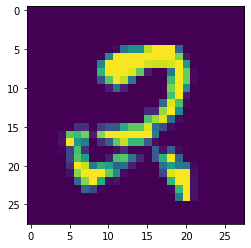

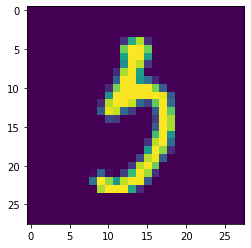

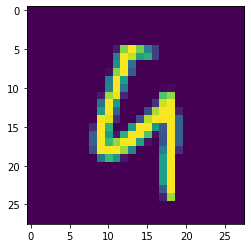

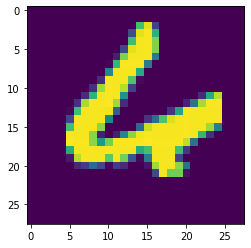

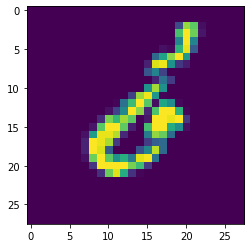

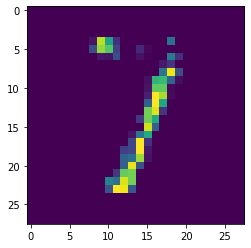

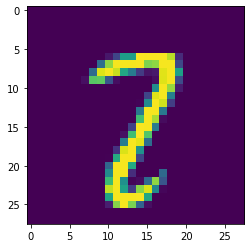

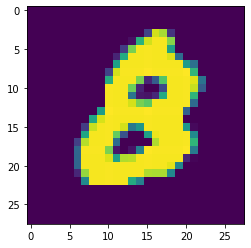

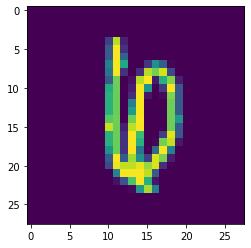

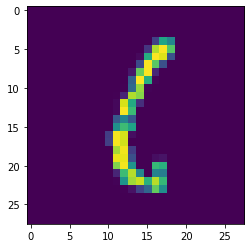

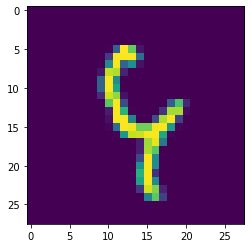

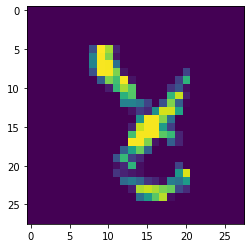

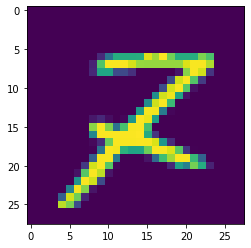

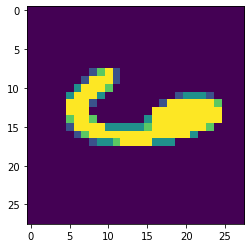

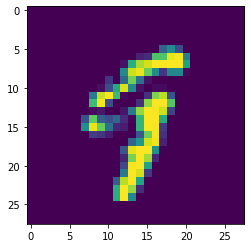

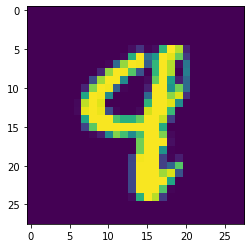

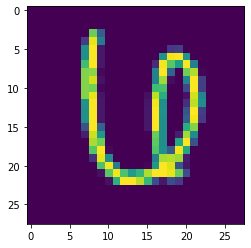

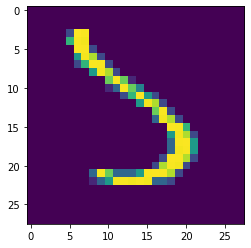

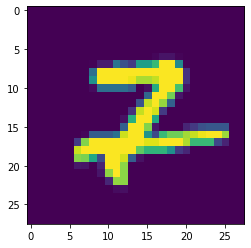

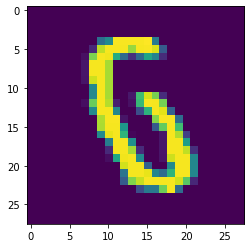

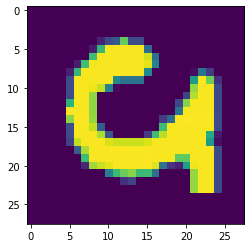

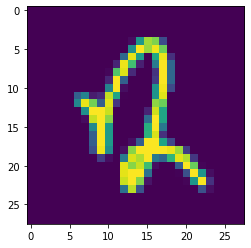

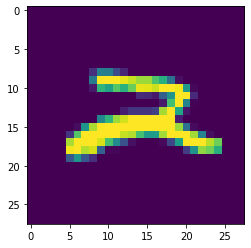

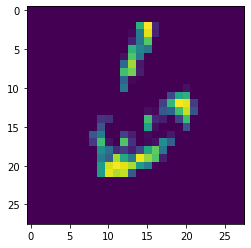

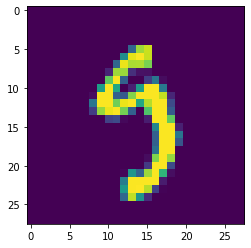

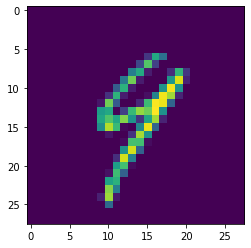

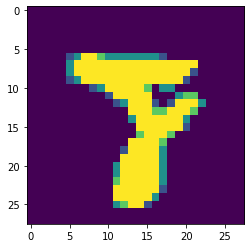

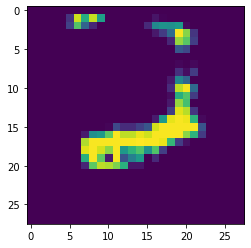

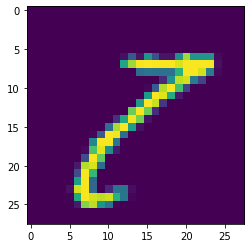

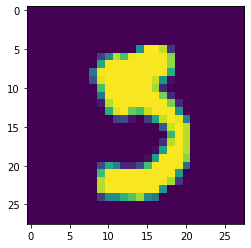

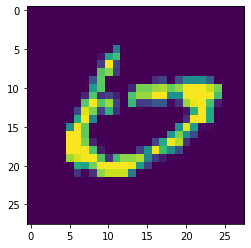

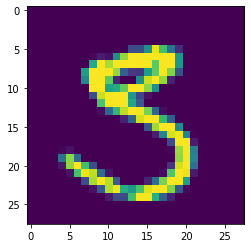

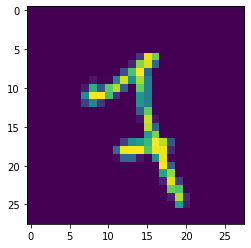

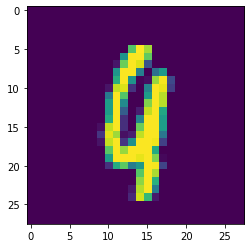

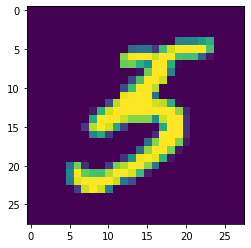

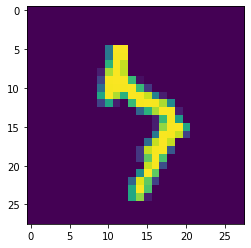

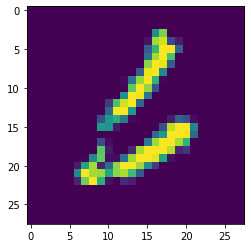

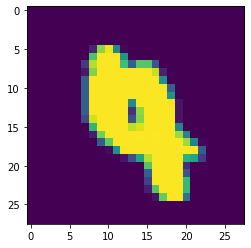

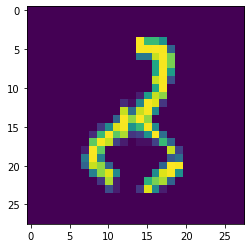

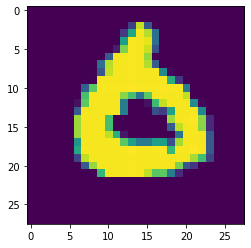

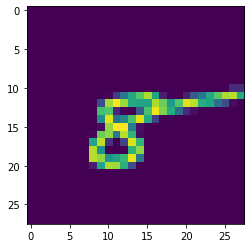

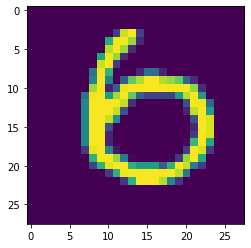

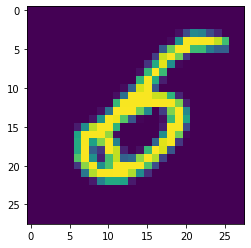

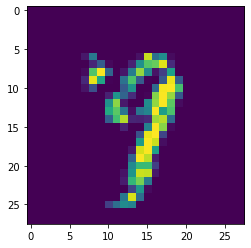

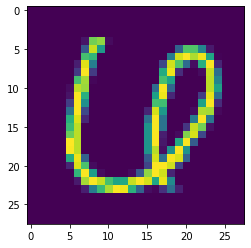

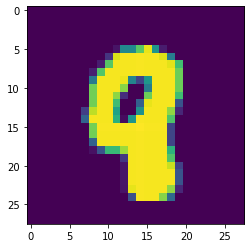

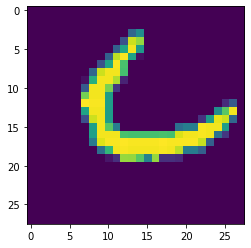

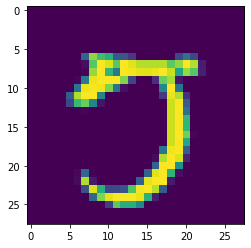

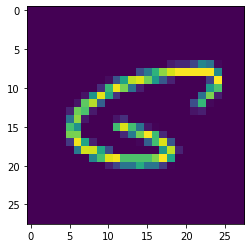

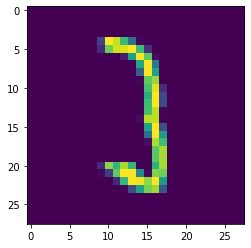

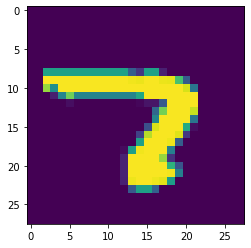

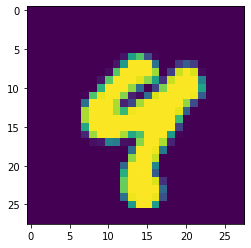

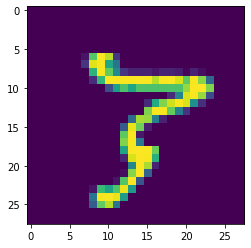

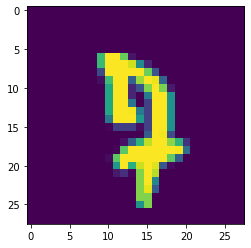

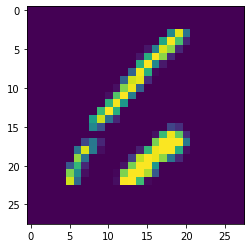

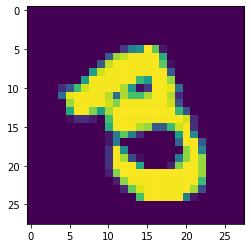

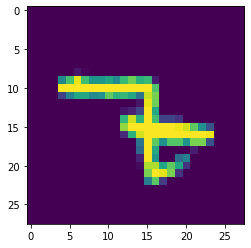

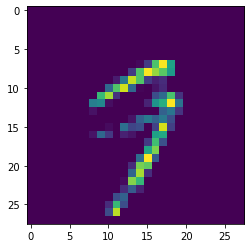

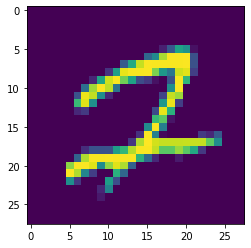

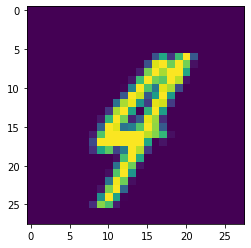

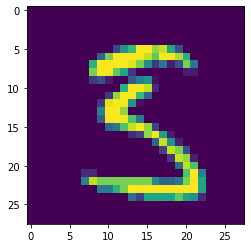

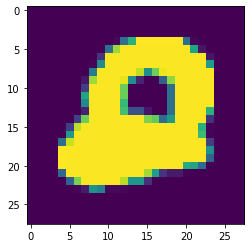

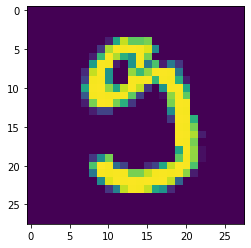

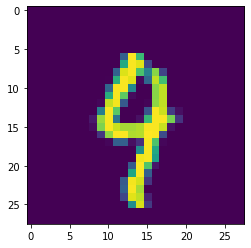

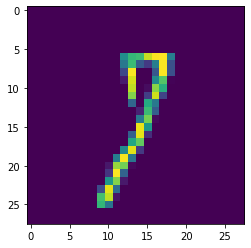

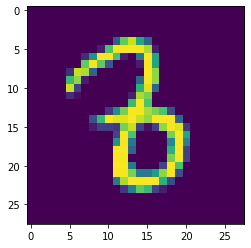

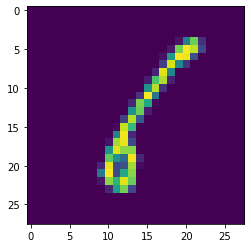


EPOCH :  19

Test set: Average loss: 0.0224, Accuracy: 9933/10000 (99%)



In [ ]:

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

for epoch in range(1, 20):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader,epoch)